# Daily Tweets Monitoring Workflow
The following notebook shows the whole workflow and results described in and the README document of this repository. The idea is to look the workflow in action, working over a dataset of tweets gathered on specific, current subject: COVID 19. The workflow is prepared sequentally, starting from the connection to the Twitter API, to the application of a clustering model and NLP processing tasks and analysis. The stages comprising this workflow are:   

1. Data Download
2. Data Preparation
3. EDA
4. Geographical Location of Tweets
5. LDA Clustering
6. Sentiment Coefficient Extraction
7. Word Shift Analysis

If you found useful this notebook, feel free to try it with other subjects or topics, or other parameters in the selection of tweets like the number of them, the information you want to extract from the Twitter API (e.g. Would you like to process info about user's favorites? or retrieve tweets only made by verified users?) The possibilities are vast and this notebook can be a good groundbase for analyzing Twitter data. Also, if you want to add other stages or think a better way to work around the present stages please let me know!

**Note #1:** The retrieving of tweets and its preparation (**Stage 1** and **Stage 2**) can take hours to complete. For that reason I work over datasets of only 10k tweets (in fact, retrieving this 10k tweets data takes me almost two days). However, is strongly encouraged to take the time to gather bigger datasets, specially for better insights in later stages. 

**Note #2:** If you want to skip **Stages 1** and **2** and jump directly to the analysis stages, you can run the cells in **Section 3.1: Load datasets** and **6.2 Load Datasets (with 'sentiments' column)**. These cells load the csv's that contains the data retrieved in the first two stages of the workflow and the one with processed sentiments coefficients respectively.

## Modules:

In [1]:
import pandas as pd
import time
import tweepy
from tqdm import tqdm, notebook
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from iso3166 import countries
import plotly.express as plotex
import re
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import itertools
import collections
from shifterator import symmetric_shift as ss
from shifterator import relative_shift as rs

## 1. Data Download 

For retrieving Twitter data, we can connect to the Twitter API, where we can make queries about multiple parameters about the users or tweets itself. In first place, we must authenticate our connection through our personal Twitter API keys:   

In [2]:
auth = tweepy.OAuthHandler('TWITTER API KEY', 'TWITTER API SECRET KEY')
api = tweepy.API(auth, wait_on_rate_limit=True)

Now that we are connected, we can make the queries for tweets data: 

### 1.1 December 10th tweets:

In [3]:
start_date = '2020-12-10' # You can choose other period here
search_words = '#covid19 -filter:retweets' # You can choose other subject here
tweets_num = 10000 # You can choose other amount of tweets here
tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en", # You can choose tweets in other language here
              since=start_date).items(tweets_num)

The previous cell produces a pointer object to the tweets and its data related. Now we must make a list with the data gathered:

In [4]:
tweets_retrieve = []
for tweet in tqdm(tweets):
     tweets_retrieve.append(tweet)

10000it [16:20, 10.19it/s]


Each element of this list is a JSON that holds all the info related to the tweet (and the tweet itself). let's see the keys for one of those tweets:

In [5]:
tweets_retrieve[0]._json.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In the last stage we will compare the language used in this day to the language used the previous week. Hence, let's download a dataset with previous week tweets:

### 1.2 Previous week tweets:

In [3]:
start_date = '2020-12-04'
search_words = '#covid19 -filter:retweets'
tweets_num = 10000
tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en",
              since=start_date).items(tweets_num)

In [4]:
tweets_retrieve_previous = []
for tweet in tqdm(tweets):
     tweets_retrieve_previous.append(tweet)

10000it [16:13, 10.27it/s]


## 2. Data preparation

In order to carry on the different analysis and stages, I would want to format the downloaded data in a dataframe fashion. For the dataframe I would want to choose only certain information present in the JSON's. In the case, I pick data related to the tweet like the date when they were created and user info (if you want to extract other tweets info, you can see the 'user_object' keys Twitter API documentation in https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object):   

### 2.1 December 10th tweets dataframe preparation:

In [ ]:
df = pd.DataFrame()
for tweet in tqdm(tweets_retrieve):
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    
    df = df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                 'user_location': tweet.user.location,
                                 'user_description': tweet.user.description,
                                 'user_created': tweet.user.created_at,
                                 'user_followers': tweet.user.followers_count,
                                 'user_verified': tweet.user.verified,
                                 'date': tweet.created_at,
                                 'text': text, 
                                 'hashtags': [hashtags if hashtags else None],
                                 'source': tweet.source}, 
                                 index=[0]))

In [ ]:
#Dec 10th dataset:
df.to_csv('covid_tweets_10000.csv')

### 2.2 Previous week tweets dataframe preparation:

In [ ]:
df_prev = pd.DataFrame()
for tweet in tqdm(tweets_retrieve_previous):
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    
    df_prev = df_prev.append(pd.DataFrame({'user_name': tweet.user.name, 
                                           'user_location': tweet.user.location,
                                           'user_description': tweet.user.description,
                                           'user_created': tweet.user.created_at,
                                           'user_followers': tweet.user.followers_count,
                                           'user_verified': tweet.user.verified,
                                           'date': tweet.created_at,
                                           'text': text, 
                                           'hashtags': [hashtags if hashtags else None],
                                           'source': tweet.source}, 
                                           index=[0]))

 72%|███████▏  | 7243/10000 [28:06:44<28:15:22, 36.90s/it]  

In [ ]:
# Previous week dataset:
df_prev.to_csv('covid_tweets_10000_previous_week.csv')

Finally, the retrieving stages are done! You most likely don't want to run the previous cells, since that take too much time to complete. You can skip them and simply run the next cells (**Section 3.1**) to load the data I gathered:

## 3. EDA

### 3.1 Load datasets:

In [2]:
#Dec 10th dataset:
df = pd.read_csv('covid_tweets_10000.csv', index_col=0)
df.head()

user_name      user_location  \
0                     Tutum Workplace    London, England   
0  Mental Health Policy Research Unit    London, England   
0                      Teemu Leinonen  Helsinki, Finland   
0                            ComeceEU           Brussels   
0                       Old Man Lefty                NaN   

                                    user_description         user_created  \
0  Tutum Workplace is a turnkey #Covid-19 testing...  2020-11-23 14:54:29   
0  The @NIHRresearch Mental Health Policy Researc...  2017-11-07 17:38:27   
0  Associate Professor, Aalto University School o...  2009-03-20 18:57:09   
0  The Commission of EU Bishops' Conferences in d...  2011-05-13 13:41:04   
0  Just an opinionated guy (some say overly) from...  2020-10-28 05:14:24   

   user_followers  user_verified                 date  \
0              10          False  2020-12-10 13:51:08   
0            4020          False  2020-12-10 13:51:07   
0            5013          False  2020-12-10 13:51:07   
0            2464          False  2020-12-10 13:51:05   
0              15          False  2020-12-10 13:51:03   

                                                text              hashtags  \
0  Tutum Workplace is the turnkey solution to saf...                   NaN   
0  Self-reported mental health worsened during #C...           ['COVID19']   
0  Here is your amateur epidemiologist again. I w...           ['COVID19']   
0  The @ComeceEu Social Affairs Commission met to...                   NaN   
0  US workers file 853K jobless claims as #COVID1...  ['COVID19', 'Trump']   

            source  
0  Twitter Web App  
0  Twitter Web App  
0  Twitter Web App  
0  Twitter Web App  
0  Twitter Web App

In [76]:
# Previous week dataset:
df_prev = pd.read_csv('covid_tweets_10000_previous_week.csv', index_col=0)

All rows have the same index, Let's reset the index:

In [77]:
#Dec 10th dataset:
df.reset_index(inplace=True, drop=True)

# Previous week dataset:
df_prev.reset_index(inplace=True, drop=True)

### 3.2 Dataframe structure:

In [5]:
df.head()

user_name      user_location  \
0                     Tutum Workplace    London, England   
1  Mental Health Policy Research Unit    London, England   
2                      Teemu Leinonen  Helsinki, Finland   
3                            ComeceEU           Brussels   
4                       Old Man Lefty                NaN   

                                    user_description         user_created  \
0  Tutum Workplace is a turnkey #Covid-19 testing...  2020-11-23 14:54:29   
1  The @NIHRresearch Mental Health Policy Researc...  2017-11-07 17:38:27   
2  Associate Professor, Aalto University School o...  2009-03-20 18:57:09   
3  The Commission of EU Bishops' Conferences in d...  2011-05-13 13:41:04   
4  Just an opinionated guy (some say overly) from...  2020-10-28 05:14:24   

   user_followers  user_verified                 date  \
0              10          False  2020-12-10 13:51:08   
1            4020          False  2020-12-10 13:51:07   
2            5013          False  2020-12-10 13:51:07   
3            2464          False  2020-12-10 13:51:05   
4              15          False  2020-12-10 13:51:03   

                                                text              hashtags  \
0  Tutum Workplace is the turnkey solution to saf...                   NaN   
1  Self-reported mental health worsened during #C...           ['COVID19']   
2  Here is your amateur epidemiologist again. I w...           ['COVID19']   
3  The @ComeceEu Social Affairs Commission met to...                   NaN   
4  US workers file 853K jobless claims as #COVID1...  ['COVID19', 'Trump']   

            source  
0  Twitter Web App  
1  Twitter Web App  
2  Twitter Web App  
3  Twitter Web App  
4  Twitter Web App

Let's take a look into the data type on the dataframe:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         10000 non-null  object
 1   user_location     8006 non-null   object
 2   user_description  9431 non-null   object
 3   user_created      10000 non-null  object
 4   user_followers    10000 non-null  int64 
 5   user_verified     10000 non-null  bool  
 6   date              10000 non-null  object
 7   text              10000 non-null  object
 8   hashtags          7194 non-null   object
 9   source            9986 non-null   object
dtypes: bool(1), int64(1), object(8)
memory usage: 713.0+ KB


We can see almost all the columns contains string data. Also, there are null values for the locations, user descriptions, hashtags used and identified app sources. Since these are data put by the user, and there are important info for our analysis in those rows, I would rather not to drop the rows with these NaN values. On the other hand, we can notice that the date column does not have an appropiate datetime format. These dates comes in this form:

In [7]:
df['date'].iloc[0]

'2020-12-10 13:51:08'

### 3.3 'date' column to date-time format:

So let's change its format for better handling:

In [5]:
df['date'] = pd.to_datetime(df.date)
print(df.date.dtype)

datetime64[ns]


In [6]:
df['date'].iloc[0]

Timestamp('2020-12-10 13:51:08')

Since these tweets correspond to only one day, it is better to take the time when tweet was written in its own column:

### 3.4 Tweet unique locations:

In [7]:
df['tweet_time'] = df.date.astype(str).str.split(expand=True)[1]

In [11]:
df.user_location.unique()

array(['London, England', 'Helsinki, Finland', 'Brussels', ...,
       'Vadodara, Gujarat, India', 'Westchester NY', 'Punjab'],
      dtype=object)

In [12]:
print ('There are {} unique locations identified in the dataframe'.format(len(df.user_location.unique())))

There are 3114 unique locations identified in the dataframe


### 3.5 Hashtags used:

Of course it is supposed that '#COVID19' predominates the hashtag landscape:

In [13]:
df.hashtags.unique()

array([nan, "['COVID19']", "['COVID19', 'Trump']", ...,
       "['SkyNews', 'COVID19', 'CovidCompliant']",
       "['Covid19', 'vaccine', 'UN', 'AntonioGuterres']",
       "['retail', 'Europe', 'stores']"], dtype=object)

However, a more useful info is usually found in the side hashtags that come along the principal. Let's see the 20 most popular groups of hashtags, skipping the principal '#COVID19' one:

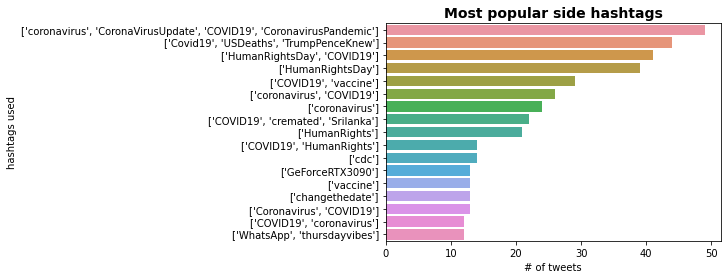

In [20]:
df_hashtags = df.hashtags.value_counts()[3:20].reset_index()
df_hashtags.rename(columns={'index':'hashtags used', 
                            'hashtags':'# of tweets'}, 
                   inplace=True)
ax = sns.barplot(x='# of tweets', 
                 y='hashtags used', 
                 data=df_hashtags)
ax.set_title('Most popular side hashtags',
             weight='bold', 
             size=14)
plt.show() 

We can start to see a certain trends that occur simultaneously with the principal one, specially in this case, since the pandemics has taken over practically all the agendas around the world. We can start to identify a Humans Rights day, and it even get to the surface marketing stuff with little relation to the virus (A graphics card?).

In [15]:
print ('There are {} hashtag groups identified in the dataframe'.format(len(df.hashtags.unique())))

There are 3609 hashtag groups identified in the dataframe


Since we can see people tend to write multiple hashtags on a single tweet, let's see how frequent single hashtag groups are repeated:

In [17]:
hashtags_count_series = df.hashtags.value_counts()
print('Number of unique groups of hashtags',len(hashtags_count_series))
print('Number repeated groups of hashtags',len(hashtags_count_series[hashtags_count_series > 1]))

Number of unique groups of hashtags 3608
Number repeated groups of hashtags 391


### 3.6 Tweets traffic by hour:

Is there any 'rush' hour on Twitter? Let's find out. First, we need to split the hour data from the created _tweet_time_ column:   

In [16]:
def extract_hour(date_str):
    '''
    Split the hour of the tweet time of creation.
    
    INPUT:
    
    date_str (str): 
        Tweet creation time
    
    OUTPUT:
    
    hour (str): 
        Tweet creation hour
    '''
    hour = date_str[:2]
    return hour

df['tweet_hour'] = df['tweet_time'].apply(extract_hour)

Now we can make the plot on this new column:

In [23]:
def hour_traffic(df, size=1):
    '''
    Makes a tweeting activity plot by hour.
    
    INPUT:
    
    df (pandas Dataframe): 
        Tweets dataframe with 'tweet_hour' column.
    
    size (int):
        Plot size.
    
    OUTPUT:
    
    
    RESULT:
    Tweeting traffic plot by hour.
    '''
    f, ax = plt.subplots(1,1, figsize=(15,4))
    total = float(len(df))
    ax_1 = sns.countplot(df['tweet_hour'], 
                         palette='Blues_d')
    
    if(size > 2):
        plt.xticks(rotation=90, size=10)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    ax_1.set_title('Tweeting traffic by hour (GMT)',
                   weight='bold', 
                   size=14)
    plt.xlabel('Hour', size=12, weight='bold')
    plt.ylabel('Tweet Count', size=12, weight='bold')
    plt.show() 

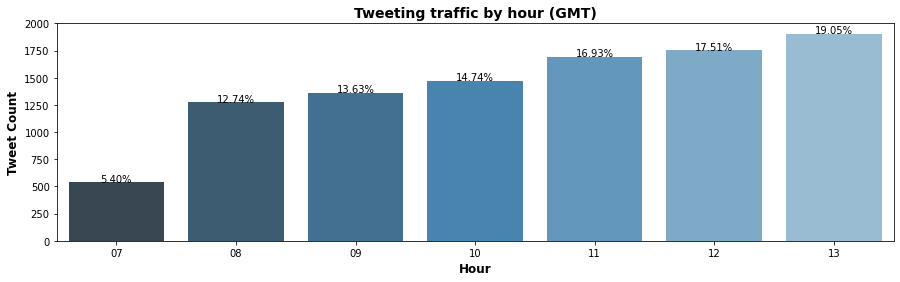

In [25]:
hour_traffic(df,size=2)

It seems that London midday is the most active time for tweeters.

### 3.7 Most active users:

What are the users who tweeted the most?

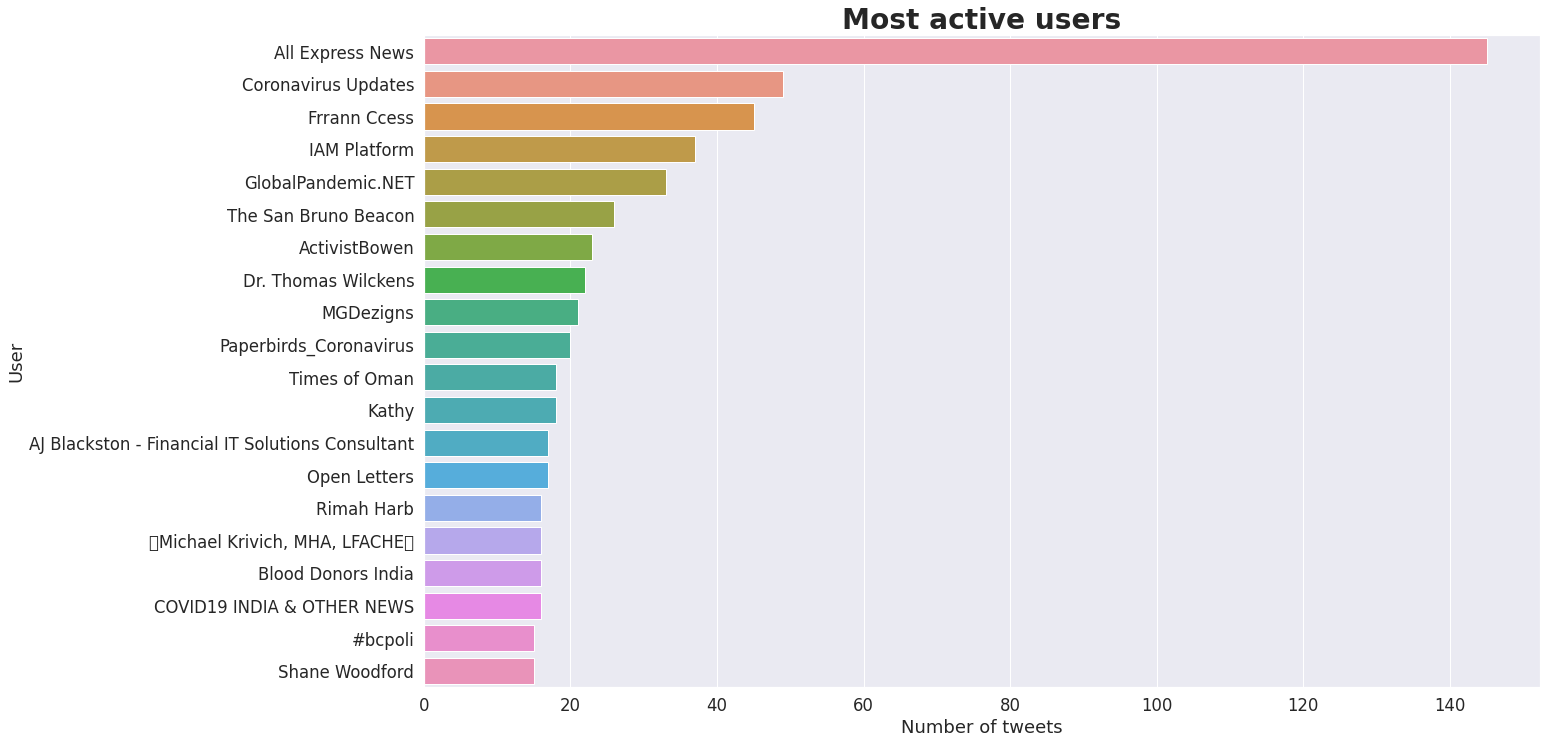

In [30]:
tweet_amount_series = df.user_name.value_counts().reset_index()
tweet_amount_series.columns = ['User', 'Number of tweets']
tweet_amount_series
plt.figure(figsize=(20,12))
ax = sns.barplot(x='Number of tweets', 
                 y='User', 
                 data=tweet_amount_series.head(20))
sns.set(font_scale=1.5)
ax.set_title('Most active users',
             weight='bold', 
             size=28) 
plt.show()

It seems that pandemics narratives are dominated by adhoc info services and news services. There is no much natural people, as expected. What if we want to know the tweeting activity of the most followed users?:   

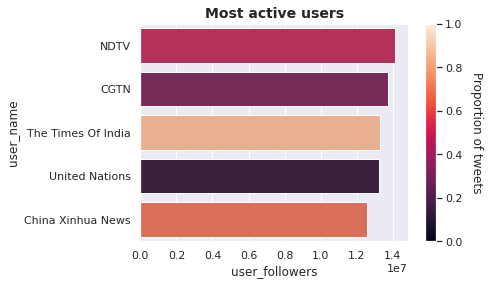

In [32]:
most_followed_series = df.sort_values('user_followers', 
                                      ascending=False)
most_followed_series.drop_duplicates(subset='user_name')

tweet_amount_series.columns = ['user_name', 
                               'Number of tweets']

most_followed_series = pd.merge(most_followed_series, 
                                tweet_amount_series, 
                                how='inner')

sns.set(font_scale=1)
normalized = plt.Normalize(most_followed_series['Number of tweets'].min(), 
                           most_followed_series['Number of tweets'].max())

scale = plt.cm.ScalarMappable(cmap='rocket')
scale.set_array([])

ax = sns.barplot(x="user_followers", 
                 y = "user_name", 
                 data = most_followed_series.head(20), 
                 hue = 'Number of tweets', dodge = False, 
                 palette = 'rocket')

ax.figure.colorbar(scale).set_label('Proportion of tweets', 
                                    rotation=270, 
                                    labelpad=20, 
                                    y=0.5)

ax.legend(loc ='lower center').remove()
ax.set_title('Most active users',
             weight='bold', 
             size=14) 
plt.show()

Again, news outlet win the race. They are more active than goverment institutions at tweeting abou the pandemic. NDTV makes almost half of the total amount of tweets.

## 4. Tweet Location 

Maybe it is useful to see the tweeting activity through the time and countries where they were written. Since the Twitter API permits us to retrieve information about the the users location, let's make an animated plot that shows the Twitter activity in this particular subject. First, notice the location format:     

In [33]:
df.user_location.iloc[0]

'London, England'

However, this is information put by the same user. There are cases that do not describe geographical places, or do not hold any place at all (NaN value). For exmaple: 

In [49]:
df.user_location.iloc[10]

'International'

### 4.1 Countries standard codes:

At the moment let's work with tweets with geographical places as locations. We need to split the country in first place:

In [8]:
df['country'] = df.user_location.str.split(',', expand=True)[1].str.strip()

And group the tweets by its country of origin:

In [9]:
df_loc = df.groupby(['tweet_time', 'user_location'])['user_name'].count().reset_index()
df_loc.rename(columns={'user_name':'quantity'}, inplace=True)
df_loc

tweet_time      user_location  quantity
0      07:31:43             Punjab         1
1      07:31:43     Westchester NY         1
2      07:31:45       Brooklyn, NY         1
3      07:31:52    California, USA         1
4      07:31:54              India         1
...         ...                ...       ...
7962   13:51:02     Rosemont, Ill.         1
7963   13:51:05           Brussels         1
7964   13:51:07  Helsinki, Finland         1
7965   13:51:07    London, England         1
7966   13:51:08    London, England         1

[7967 rows x 3 columns]

With help of iso lookups we can standardize the countries found in thei alpha3 codes, let's make a dictionary of codes:

In [10]:
countries_dict = {}
for country in countries:
    countries_dict[country.name] = country.alpha3

countries_dict

{'Afghanistan': 'AFG',
 'Åland Islands': 'ALA',
 'Albania': 'ALB',
 'Algeria': 'DZA',
 'American Samoa': 'ASM',
 'Andorra': 'AND',
 'Angola': 'AGO',
 'Anguilla': 'AIA',
 'Antarctica': 'ATA',
 'Antigua and Barbuda': 'ATG',
 'Argentina': 'ARG',
 'Armenia': 'ARM',
 'Aruba': 'ABW',
 'Australia': 'AUS',
 'Austria': 'AUT',
 'Azerbaijan': 'AZE',
 'Bahamas': 'BHS',
 'Bahrain': 'BHR',
 'Bangladesh': 'BGD',
 'Barbados': 'BRB',
 'Belarus': 'BLR',
 'Belgium': 'BEL',
 'Belize': 'BLZ',
 'Benin': 'BEN',
 'Bermuda': 'BMU',
 'Bhutan': 'BTN',
 'Bolivia, Plurinational State of': 'BOL',
 'Bonaire, Sint Eustatius and Saba': 'BES',
 'Bosnia and Herzegovina': 'BIH',
 'Botswana': 'BWA',
 'Bouvet Island': 'BVT',
 'Brazil': 'BRA',
 'British Indian Ocean Territory': 'IOT',
 'Brunei Darussalam': 'BRN',
 'Bulgaria': 'BGR',
 'Burkina Faso': 'BFA',
 'Burundi': 'BDI',
 'Cambodia': 'KHM',
 'Cameroon': 'CMR',
 'Canada': 'CAN',
 'Cabo Verde': 'CPV',
 'Cayman Islands': 'CYM',
 'Central African Republic': 'CAF',
 'Chad': 

In [11]:
df_loc['country_code'] = df_loc['user_location']
df_loc = df_loc.replace({'country_code': countries_dict})

In [56]:
df_loc

tweet_time      user_location  quantity       country_code
0      07:31:43             Punjab         1             Punjab
1      07:31:43     Westchester NY         1     Westchester NY
2      07:31:45       Brooklyn, NY         1       Brooklyn, NY
3      07:31:52    California, USA         1    California, USA
4      07:31:54              India         1                IND
...         ...                ...       ...                ...
7962   13:51:02     Rosemont, Ill.         1     Rosemont, Ill.
7963   13:51:05           Brussels         1           Brussels
7964   13:51:07  Helsinki, Finland         1  Helsinki, Finland
7965   13:51:07    London, England         1    London, England
7966   13:51:08    London, England         1    London, England

[7967 rows x 4 columns]

There is a problem with the code of UK and United States, and the way we normally call these countries, that is, rarely we call 'United States of America' (it's formal name), let's see this problem in the dataframe itself: 

In [13]:
df_loc[df_loc['country_code']=='United States'].country_code = 'USA'

In [14]:
uk_list = ['United Kingdom', 'England', 'UK']
us_list = ['United States']
df_loc = df_loc[(df_loc.country_code == 'USA')|(df_loc['user_location'].isin(uk_list))|(df_loc.user_location != df_loc.country_code)]
df_loc = df_loc.groupby(['tweet_time', 'user_location', 'country_code'])['quantity'].sum().reset_index()
df_loc[df_loc['country_code']=='United States'].country_code = 'USA'
df_loc.head()

tweet_time user_location country_code  quantity
0   07:31:54         India          IND         1
1   07:32:47           USA          USA         1
2   07:32:56           USA          USA         1
3   07:33:08        Canada          CAN         1
4   07:33:19     Singapore          SGP         1

Due to the dataset is not too big, there is no much tweets made at a certain moment (3 max): 

In [64]:
df_loc.quantity.unique()

array([1, 3, 2])

Now we are ready for the tweeting activity animation:

In [15]:
fig = plotex.choropleth(
    df_loc, 
    locations='country_code',
    hover_name='user_location',
    color='quantity',
    animation_frame='tweet_time',
    projection="natural earth",
    color_continuous_scale=plotex.colors.sequential.Plasma,
    title='Tweet Location through time',
    width=800, 
    height=600
)
fig.show()

## 5. LDA Clustering

We can get a sense of the possible multiple topics in the dataset with a natural language processing clustering technique known as Latent Dirichlet Allocation (LDA), where we can group and identify unknown patterns in clusters for a set of documents, based on the word content of each one of them. This model start with the intuition that a certain document can be seen as a mixture of different topics and each topic is characterized by a set of words that compose it. Therefore, each document is characterized by the likelihood of each word in it to belong to certain topic, each one of them automatically identified at analyzing the other documents in he corpus. To carry on this model on our tweets, we must clean the texts in order to avoid potential ambiguities or non-significant symbols and input the model with relevant terms of each tweet. The next function take care of that        

### 5.1 Text cleaning:

In [80]:
def clean_tweets(tweet):
    '''
    Remove stopwords, mentions, URL's and numbers from a tweet text 
    Also lower case it and removes special characters like the # in 
    hashtags.
    
    INPUT:
    
    tweet (str): 
        Tweet text
    
    OUTPUT:
    
    clean_tweet (str): 
        Clean tweet text
    '''
    stop_words = set(stopwords.words('english'))
    tweet = tweet.lower()
    clean_tweet = re.sub(r'@\w+',' ', tweet)
    clean_tweet = re.sub(r' \d+',' ', clean_tweet)
    clean_tweet = re.sub(r' \d+ ',' ', clean_tweet)
    clean_tweet = re.sub(r'http\S+',' ', clean_tweet)
    clean_tweet = re.sub(r'\n',' ', clean_tweet)
    clean_tweet = re.sub(r'#','', clean_tweet)
    clean_tweet = clean_tweet.split()
    clean_tweet = " ".join([word for word in clean_tweet if not word in stop_words])
    
    return clean_tweet

Now we create a new column _'clean_text'_ where we take as the input of our LDA clustering model: 

In [81]:
df['clean_text'] = df.text.apply(clean_tweets)
df.head()

user_name      user_location  \
0                     Tutum Workplace    London, England   
1  Mental Health Policy Research Unit    London, England   
2                      Teemu Leinonen  Helsinki, Finland   
3                            ComeceEU           Brussels   
4                       Old Man Lefty                NaN   

                                    user_description         user_created  \
0  Tutum Workplace is a turnkey #Covid-19 testing...  2020-11-23 14:54:29   
1  The @NIHRresearch Mental Health Policy Researc...  2017-11-07 17:38:27   
2  Associate Professor, Aalto University School o...  2009-03-20 18:57:09   
3  The Commission of EU Bishops' Conferences in d...  2011-05-13 13:41:04   
4  Just an opinionated guy (some say overly) from...  2020-10-28 05:14:24   

   user_followers  user_verified                 date  \
0              10          False  2020-12-10 13:51:08   
1            4020          False  2020-12-10 13:51:07   
2            5013          False  2020-12-10 13:51:07   
3            2464          False  2020-12-10 13:51:05   
4              15          False  2020-12-10 13:51:03   

                                                text              hashtags  \
0  Tutum Workplace is the turnkey solution to saf...                   NaN   
1  Self-reported mental health worsened during #C...           ['COVID19']   
2  Here is your amateur epidemiologist again. I w...           ['COVID19']   
3  The @ComeceEu Social Affairs Commission met to...                   NaN   
4  US workers file 853K jobless claims as #COVID1...  ['COVID19', 'Trump']   

            source tweet_time  tweet_hour  country  \
0  Twitter Web App   13:51:08          13  England   
1  Twitter Web App   13:51:07          13  England   
2  Twitter Web App   13:51:07          13  Finland   
3  Twitter Web App   13:51:05          13      NaN   
4  Twitter Web App   13:51:03          13      NaN   

                                          clean_text  sentiment  \
0  tutum workplace turnkey solution safer working...        0.3   
1  self-reported mental health worsened covid19 s...       -0.5   
2  amateur epidemiologist again. reading covid19 ...        0.0   
3  social affairs commission met discuss put forw...        0.4   
4  us workers file k jobless claims covid19 -19 s...       -0.6   

  identified_feeling  
0           Positive  
1           Negative  
2            Neutral  
3           Positive  
4           Negative

### 5.2 Model fitting:

Now we can fit our mode. The model demands two things: First, we must define what is the corpus we want to process, and second, apply a vectorizer that take into account the frequency of the words in each of the clean tweets and weights its importance over all the different texts through a Tfidf technique:

In [82]:
corpus = list(df.clean_text)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print('Number of words identified by the Tfidf Vectorizer: {}'.
      format(len(vectorizer.get_feature_names())))

Number of words identified by the Tfidf Vectorizer: 23850


Like other unsupervised clustering algorithms, LDA models require to choose the number of clusters we want to classify the corpus into, according our classification needs or the resulting words and that characterizes the different topics/clusters. I choose to classify the corpus in two clusters to explore if this model can give us a preliminary sense of the emotion content on the tweets (feeling good or feeling sad tweets). After multiple intents, where I can see no special trends in clusters (and the special feature that, in principle, all the tweets share the same principal subject), I found that these parameters give an interesting result:      

In [83]:
lda_tf_chats = LatentDirichletAllocation(n_components=2, 
                                         random_state=0, 
                                         learning_decay=0.7, 
                                         learning_offset=10.0,
                                         max_doc_update_iter=100)
lda_tf_chats.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### 5.3 Result:
The **pyLDAvis** module permits us to interact with the clusters found by the model:

In [84]:
pyLDAvis.sklearn.prepare(lda_tf_chats, X, vectorizer)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.068297  0.0       1        1  63.405136
1     -0.068297  0.0       2        1  36.594864, topic_info=              Term       Freq      Total Category  logprob  loglift
3815         cases  71.000000  71.000000  Default  30.0000  30.0000
6022        deaths  48.000000  48.000000  Default  29.0000  29.0000
5192   coronavirus  96.000000  96.000000  Default  28.0000  28.0000
22453      vaccine  97.000000  97.000000  Default  27.0000  27.0000
21723        trump  35.000000  35.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
14609         news  17.477666  29.851040   Topic2  -6.6757   0.4700
20006        state  15.213847  20.212316   Topic2  -6.8144   0.7212
21372        today  17.433888  55.638638   Topic2  -6.6782  -0.1552
22372           us  17.485209  58.054739   Topic2  -6.6753  -0.1948
15584     pandemic  16.812194  88.235752   Topic2  -6.7145  -0.6526

[147 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1          1  0.076630        000
1          2  0.919561        000
69         1  0.072023         10
69         2  0.936301         10
105        2  1.001108         12
...      ...       ...        ...
23562      1  0.857676       year
23562      2  0.155941       year
23582      1  0.108395  yesterday
23582      2  0.867161  yesterday
23610      1  0.995127        you

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

Each one of the circles in the left side represent a cluster. It's size gives us a notion of the amount of tweets gathered under the same topic suggested by the model. It's location give us information about how similar are the identified topics (and therefore the characteristic words that push away the clusters in this principal components representation space). On the right side, if the cursor does not hover over any of the clusters, we can see the most representative words over the whole corpus. If we hover over any cluster, we can see the most representative words of this specific topic/cluster, followed by bars that shows the relevance of each word within the cluster. In our case, we can notice:

- The principal subject 'covid 19' dominates the global landscape, as expected.  
- The hashtags identified in section 3.5 play a relevant role in the found clusters.
- It seems that there are two main topics: The right one related to the overcome of the pandemic with terms like 'health' or 'vaccine' or the humans rights day previously identified  (maybe the topic is 'optimism'?), and the smaller left one related to a more 'bad news' approach with words like 'deaths', or 'positive' (of course trump politics cannot be absent on this diagram). 
- The alleged unrelated covid terms like 'ps5gamers' or 'xbox' belongs to the right cluster.

Is it possible to capture these good/bad feelings in the dataset through other algorithms? Let's find out in the next stage!

## 6. Sentiment Coefficient Extraction
We can make use of the Google Natural Language API for comprehend and analyze text corpus. Particularly, this API have methods for identifying the overall emotion that dominate a particular text as positive, negative and neutral. Behind the curtain the API uses Machine Learning models pretrained by Google over vast set of texts and training sessions. Specifically, the _analyze_sentiment( )_ method identifies the predominant emotion in a text and gives the following numeric results at the moment of processing a certain text:

 - **Score coefficient:** A number between -1.0 and 1.0 that maps the general, predominant positive/negative emotion. 
 - **Magnitude coefficient:** A number between 0.0 and infinity that maps the amount of ‘emotional content’ within a text. This helps to identify if a text got a mix of positive and negative emotions linked or is a truly neutral text (low emotional content).

Let's apply this API method over the clean text in both datasets: Dec 10th and previous week datasets  and saves the score coefficients obtained in a new column of the tweets dataframe: sentiment. First, let's clean the tweets on the previous week dataset:

In [78]:
df_prev['clean_text'] = df_prev.text.apply(clean_tweets)

### 6.1 Scores Extraction:

The following functions cover four steps in order to get the sentiment scores for each tweet:

1. Connects to the Google Cloud Natural Language API through a client.
2. Define the type of texts we are gone to process and their language.
3. Computes the sentiment scores over the clean tweets text.
4. Builds the score column in the dataframe processed

In [55]:
def get_sentiment(content):
    '''
    Connects to Google Cloud Natural Language API, set the type of document
    to be processed and call the analyze_sentiment method.
    
    INPUT:
    
    content (str): 
        Text to be processed.
    
    OUTPUT:
    
    result(annotations) (int): 
        sentiment score computed for content.
    '''
    client = language.LanguageServiceClient()
    document = types.Document(
                content=content,
                type=enums.Document.Type.PLAIN_TEXT,
                language='en')
    annotations = client.analyze_sentiment(document=document)
    return result(annotations)

In [56]:
def result(annotations):
    '''
    Extract the sentiment score from the result dictionary returned by 
    the analyze_sentiment method within get_sentiment function.
    
    INPUT:
    
    annotations (dict): 
        Results obtained by analyze_sentiment method application (text processed
        and score and magnitude obtained).
    
    OUTPUT:
    
    score (int): 
        sentiment score computed.
    '''    
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude
    for index, sentence in enumerate(annotations.sentences):
        sentence_sentiment = sentence.sentiment.score
    return score

In [59]:
def compute_sentiments(dataframe):
    '''
    Builds 'sentiment' column on dataframe with the scores computed for
    each cleaned tweet.
    
    INPUT:
    
    dataframe (pandas Dataframe): 
        Dataframe with a 'clean text' column.
    
    OUTPUT:
    
    RESULT:
    Dataframe with sentiment scores computed.
    '''    
    sentiment = []
    for text in tqdm(dataframe.clean_text):
        sentiment.append(get_sentiment(text))
        time.sleep(.100)
    dataframe['sentiment'] = sentiment

Let's compute the scores for both datasets and conffirm the 'sentiment' column was created:

In [79]:
# Dec 10th dataset:
compute_sentiments(dataframe=df)

100%|██████████| 10000/10000 [27:49<00:00,  5.99it/s] 


In [85]:
# Previous week dataset:
compute_sentiments(dataframe=df_prev)

100%|██████████| 10000/10000 [28:10<00:00,  5.91it/s] 


In [110]:
# Dec 10th dataset:
df.head(1)

user_name    user_location  \
0  Tutum Workplace  London, England   

                                    user_description         user_created  \
0  Tutum Workplace is a turnkey #Covid-19 testing...  2020-11-23 14:54:29   

   user_followers  user_verified                 date  \
0              10          False  2020-12-10 13:51:08   

                                                text hashtags  \
0  Tutum Workplace is the turnkey solution to saf...      NaN   

            source tweet_time  tweet_hour  country  \
0  Twitter Web App   13:51:08          13  England   

                                          clean_text  sentiment  \
0  tutum workplace turnkey solution safer working...        0.3   

  identified_feeling  
0           Positive

In [111]:
# Previous week dataset:
df_prev.head(1)

user_name   user_location              user_description  \
0  Diana "Sunshine" Wulf  Nebraska, USA,  SHOW ME WHAT YOU GOT!   ☀️🌖✨   

          user_created  user_followers  user_verified                 date  \
0  2009-05-23 02:16:48            3489          False  2020-12-04 13:13:30   

                                                text     hashtags  \
0  @PrisonPlanet Low-Level "Marijuana Offenders" ...  ['COVID19']   

            source                                         clean_text  \
0  Twitter Web App  low-level "marijuana offenders" “pay rent” law...   

   sentiment  
0       -0.1

And save them:

In [87]:
# Dec 10th dataset:
df.to_csv('covid_tweets_sentiments.csv')

# Previous week dataset:
df_prev.to_csv('covid_tweets_sentiments_previous_week.csv')

### 6.2 Load Datasets (with 'sentiments' column):

In [3]:
# Dec 10th dataset:
df = pd.read_csv('covid_tweets_sentiments.csv', index_col=0)

# Previous week dataset:
df_prev = pd.read_csv('covid_tweets_sentiments_previous_week.csv', index_col=0)

In [4]:
df_pos = df.loc[df.sentiment > 0.0]
print('Number of positive tweets: {}'.format(df_pos.shape[0]))

Number of positive tweets: 3461


In [5]:
df_neutral = df.loc[df.sentiment == 0.0]
print('Number of neutral tweets: {}'.format(df_neutral.shape[0]))

Number of neutral tweets: 2728


In [6]:
df_neg = df.loc[df.sentiment < 0.0]
print('Number of negative tweets: {}'.format(df_neg.shape[0]))

Number of negative tweets: 3811


In [36]:
df_prev_pos = df_prev.loc[df_prev.sentiment > 0.0]
df_prev_neg = df_prev.loc[df_prev.sentiment < 0.0]
df_prev_neutral = df_prev.loc[df_prev.sentiment == 0.0]

### 6.3 Tweet Sentiments Stats:

Let's see the rate of positive, neutral and negative tweets in both datasets bar plot of tweets by sentiment. First, let's assign categories for each range of scores:

In [124]:
def assign_feeling(dataframe):
    '''
    Assigns sentiment category to each tweet sentiment 
    score (Positive, Negative and Neutral).
    
    INPUT:
    
    dataframe (pandas Dataframe): 
        Dataframe with a 'sentiment' column.
    
    OUTPUT:
    
    RESULT:
    Dataframe with sentiment categories assigned.
    '''
    dataframe['identified_feeling'] = dataframe['sentiment'].apply(lambda x: 
                                                     'Positive' if x > 0 else 
                                                     ('Negative' if x < 0 else 
                                                      'Neutral'
                                                     )
                                                    )

Let's apply the function and conffirm that both datasets have sentiment categories assigned:

In [103]:
# Dec 10th dataset:
assign_feeling(df)
index=0
print('Feeling identified in tweet {}: {}'.format(index, df.identified_feeling.iloc[index]))

Feeling identified in tweet 0: Positive


In [125]:
# Previous week dataset:
assign_feeling(df_prev)
index_prev=1
print('Feeling identified in tweet {}: {}'.format(index_prev, df_prev.identified_feeling.iloc[index_prev]))

Feeling identified in tweet 1: Negative


Now we can get a plot that groups the tweets by the emotion identified by the GCP Natural Language API. Let's see if there is any change in the elapsed week:

In [95]:
def plot_sentiments_stats(dataframe, date):
    '''
    Plots a barplot with tweets grouped by sentiment computed.
    
    INPUT:
    
    dataframe (pandas Dataframe): 
        Dataframe with a 'identified_feeling' column.
        
    date (str):
        Plot title date. 

    OUTPUT:
    
    RESULT:
    barplot with dataframe tweets grouped by sentiment computed.
    '''
    ax = sns.barplot(x='index', 
                     y='identified_feeling',
                     data=dataframe.identified_feeling.value_counts().reset_index())
    ax.set_title('Tweets by identified emotion ({})'.format(date),
                 weight='bold', 
                 size=14)
    ax.set_xlabel('Identified feeling',
                 weight='light', 
                 size=12)
    ax.set_ylabel('Tweet count',
                 weight='light', 
                 size=12)
    plt.show()

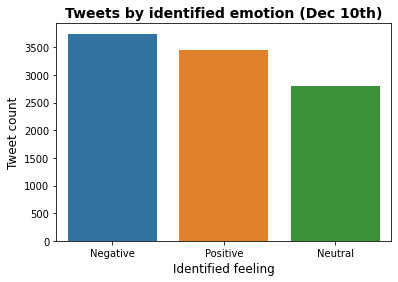

In [107]:
# Dec 10th dataset:
plot_sentiments_stats(dataframe=df, date='Dec 10th')

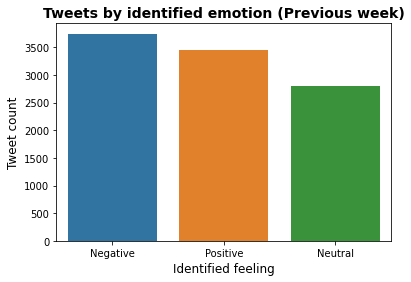

In [126]:
# Previous week dataset:
plot_sentiments_stats(dataframe=df_prev, date='Previous week')

jmmmm... the plots almost look the same. Let's see if numbers give us a better view:

In [47]:
# Dec 10th dataset:
df.identified_feeling.value_counts()

Negative    3811
Positive    3461
Neutral     2728
Name: identified_feeling, dtype: int64

In [90]:
# Previous week dataset:
df_prev.identified_feeling.value_counts()

Negative    3747
Positive    3444
Neutral     2809
Name: identified_feeling, dtype: int64

Indeed, their numbers are very similar. It seems that there is no significant change in the narrative's emotions in this week. Although the good/bad feelings rate remains the same, maybe there are different words or events that push the emotions between the two periods, Let's find out. 

## 7. Word Shift Analysis
Since we have a sentiment coefficient linked to each tweet, we can use this to look if the sentiments and language have changed over time in tweets. For this, we can lean on the _Word Shift_ analysis with the help of the **shifterator** module. The purpose of this analysis is to identify in a diagram the words that push the most emotional content, and see its change compared to a similar dataset previously recorded. In our case, I would want to compare the tweets created on Dec 10, 2020 with tweets created the previous week, on Dec 4th, 2020.

_Word Shift_ is a tecnique for visualizing the words that contributes to the difference between two texts that involves "... common text comparison measurse, including relative frequency, Shannon entropy, Tsallis entropy, the Kullback-Leibler divergence, and the Jensen-Shannon divergence" (https://shifterator.readthedocs.io/_/downloads/en/latest/pdf/). 

In our case, we will compare which words push forward the negative/positive feeling tweetsand see if there is a change in the language used. As a starting point, let's build the corpus we are going to analyze, the clean tweet texts: 

### 7.1 Whole datasets corpus:

In [26]:
present_texts = df.clean_text
previous_texts = df_prev.clean_text

The input must take the structure of a word frequency dictionary that resumes the appeareance of all the words in the corpus for each dataset we want to compare. Since _Word_Shift_ works with word frequency dictionaries and does not distinguish between real words and punctuation marks, this symbols can be counted on the diagram. For these reason it is necessary to remove them: 

In [8]:
def remove_punctuation(text):
    """
    Removes punctuation from text.
    
    INPUT:
    
    text (str): 
        Text to be processed.

    OUTPUT:
    
    cleaned (str):
        Cleaned text.     
    """
    cleaned = " ".join(re.sub(r'([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', text).split())
    
    return cleaned

Now we can make the word frequency dictionaries, with the help of Python builtin **collections** model:

In [9]:
def make_freq_dict(text):
    """
    Clean stopwords and builds word frequency dictionary text.
    
    INPUT:
    
    text (str): 
        Text to be analyzed.

    OUTPUT:
    
    freq_dict (Counter):
        Counter dictionary object withh word word:frequency pairs.     
    """
    stop_words = set(stopwords.words('english'))
    freq_dict = [remove_punctuation(term) for term in text]
    freq_dict = [term.lower().split() for term in freq_dict]    
    freq_dict = [[word for word in term if not word in stop_words]
              for term in freq_dict]    
    freq_dict = list(itertools.chain(*freq_dict))
    freq_dict = collections.Counter(freq_dict)
        
    return freq_dict

In [27]:
clean_present_texts = make_freq_dict(present_texts)
clean_previous_texts = make_freq_dict(previous_texts)

### 7.2 Whole datasets comparison:

Now we are ready to build the plot. In particular, we are going to use the Jensen and Shannon Divergence Shift, which is a statistical method for comparing two probability distributions (In our case the distributions givem by the word frequencies):

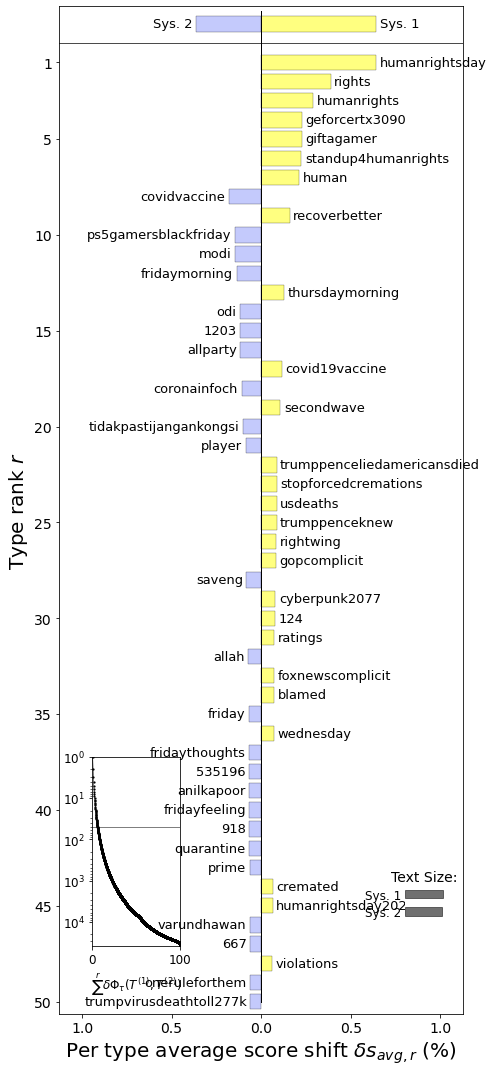

In [40]:
jsd_shift = ss.JSDivergenceShift(system_1=clean_present_texts,
                                 system_2=clean_previous_texts,
                                 base=2)
                                 
jsd_shift.get_shift_graph()

In the above diagram we can see a set of words at each side of an axis, followed by colored bars. The words at the left size are the words that push the most emotional content scores within the tweets written in the Dec 10th tweets, compared to the past week tweets, and their relative impact on these scores (for example 'humanrightsday' push the most emotional tweets in Dec 10th compared to the past week). On the other hand, words like 'covidvaccine' or 'allparty' marked the differences in past week tweets compared to the Dec 10th tweets. On the upper side, we can see the global aggregate of the impact of these words, that is, how much the words on each side of the axis push the emotional content of Dec 10th tweets, compared with the past week tweets. It seems that this week were more active, both in positive and negative tweets. What about the positive scored tweets? Let's see:

### 7.3 Positive tweets comparison:

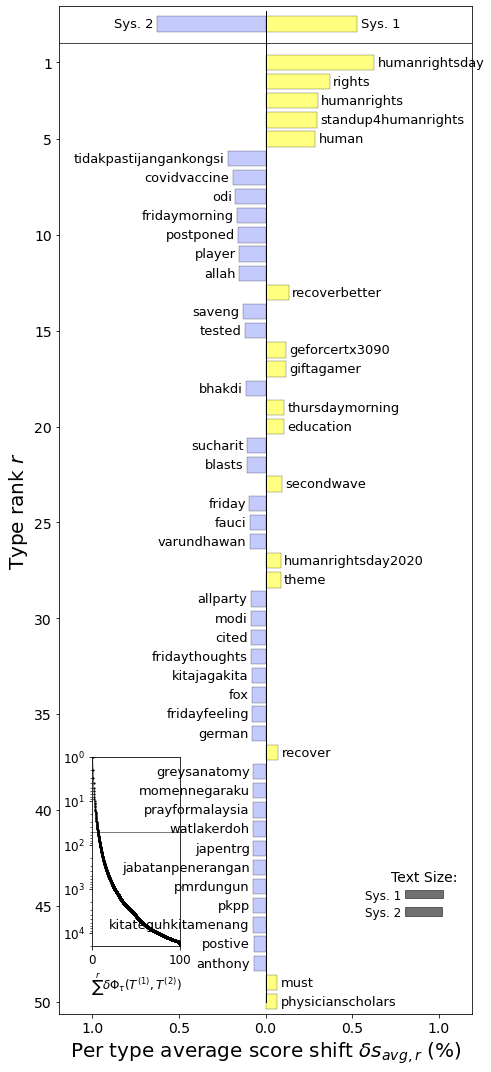

In [46]:
present_texts = df_pos.clean_text
previous_texts = df_prev_pos.clean_text

clean_present_texts = make_freq_dict(present_texts)
clean_previous_texts = make_freq_dict(previous_texts)

jsd_shift = ss.JSDivergenceShift(system_1=clean_present_texts,
                                 system_2=clean_previous_texts,
                                 base=2)
                                 
jsd_shift.get_shift_graph()

It seems that past week were more positive than Dec 10th, although the humans rights day were more relevant in positive interactions. What about negative tweets?

### 7.4 Negative tweets comparison:

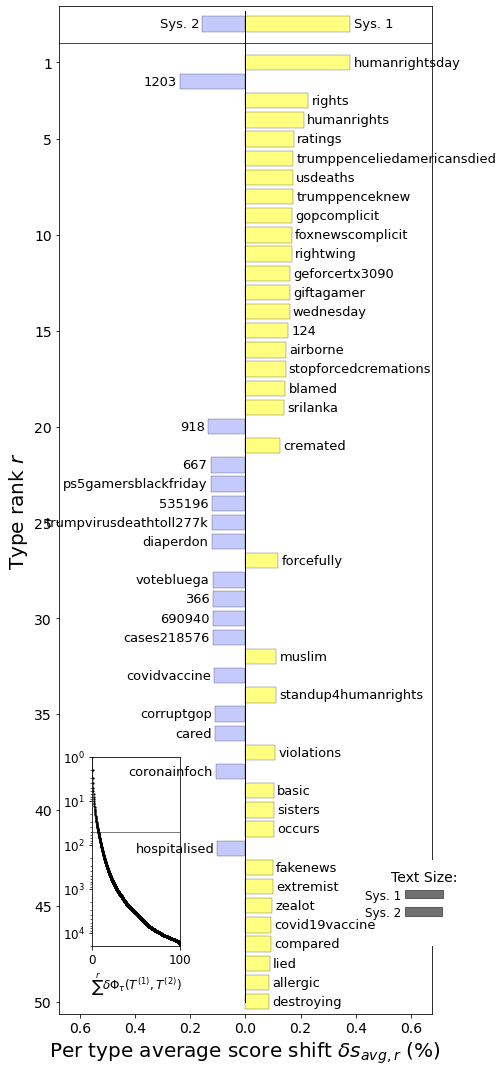

In [47]:
present_texts = df_neg.clean_text
previous_texts = df_prev_neg.clean_text

clean_present_texts = make_freq_dict(present_texts)
clean_previous_texts = make_freq_dict(previous_texts)

jsd_shift = ss.JSDivergenceShift(system_1=clean_present_texts,
                                 system_2=clean_previous_texts,
                                 base=2)
                                 
jsd_shift.get_shift_graph()

There is a clearly increment in negative score margins in this week tweets. This may indicate rising controversies or more pugnacity on existing ones. For example, humans rights day lead this diagram too!. Also, american GOP policies seems to have a more controversial week.  

### 7.5 Neutral tweets comparison:

In [37]:
present_texts = df_neutral.clean_text
previous_texts = df_prev_neutral.clean_text

clean_present_texts = make_freq_dict(present_texts)
clean_previous_texts = make_freq_dict(previous_texts)

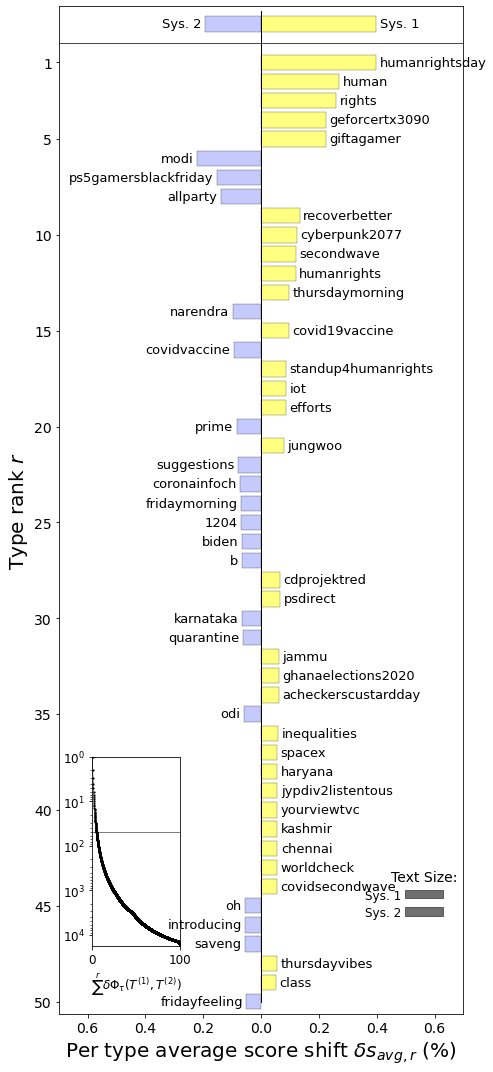

In [38]:
jsd_shift = ss.JSDivergenceShift(system_1=clean_present_texts,
                                 system_2=clean_previous_texts,
                                 base=2)
                                 
jsd_shift.get_shift_graph()

Finally, on the neutral tweets we can identify a lot of terms that seem unrelated to the pandemics. This diagram looks like the 'normal' days comparative, were a variety of themes coexist in the top most popular topics (Curiously, Biden finally appears on stage!).  

## Conclusion
The presented workflow aims to show insights on tweets through techniques that involve a correct retrieving of data, preparation of relevant information within a dataframe, NLP preprocessing tasks and statistical assisted tools whose ultimate purpose is to show insights that may be hidden on Twitter people's interactions. Of course, this workflow is perfectible. This work only cover certain tasks and so much data of interest can be extracted and processed through adding new steps or stages. For example, a deeper analysis of the hashtags that accompany the target hashtag I´m looking for or characterization of the users in the dataset according to their followers or retweetings, are interesting additional stages that are possible within the same framework of collecting tweets through the Twitter API and this workflow. If you can think of other stages or ways to extract insights of tweets based on this code, I’m more than interested to see them in action! Bring it on!